## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
import random
from lib.dataset import peek_pairs

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset


In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"
DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"

VERSION_TAG = "0.4.2-53"
BUILD_MODEL = True

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_validation_dataset = deeplake.load(f'{DATASET_DATA_PATH}/validation')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_validation_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', read_only=True, tensors=['images', 'labels'])

 tensor      htype            shape           dtype  compression
 -------    -------          -------         -------  ------- 
 images      image     (11218, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (11218, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/validation', read_only=True, tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (1608, 224, 224, 3)   uint8    jpeg   
 labels   class_label       

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)



In [3]:
DIMENSIONS = 224
BATCH_SIZE = 48
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_EPOCH = 10
EPOCHS = 30
LEARNING_RATE = 0.0001

In [4]:
data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)

print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline


In [5]:
raw_training_dataset = raw_training_dataset.tensorflow()
raw_validation_dataset = raw_validation_dataset.tensorflow()
raw_testing_dataset = raw_testing_dataset.tensorflow()

In [6]:
def group_dataset(raw_dataset):
    data_by_label = {}

    for data in raw_dataset:
      label = data['labels'].numpy().item()
      if label not in data_by_label:
          data_by_label[label] = []
      data_by_label[label].append(data)

    return data_by_label

grouped_training_dataset = group_dataset(raw_training_dataset)
grouped_validation_dataset = group_dataset(raw_validation_dataset)
grouped_testing_dataset = group_dataset(raw_testing_dataset)

def data_generator(steps_per_epoch, dataset):
    grouped_dataset = None
    match dataset.decode():
        case "training":
            grouped_dataset = grouped_training_dataset
        case "validation":
            grouped_dataset = grouped_validation_dataset
        case "testing":
            grouped_dataset = grouped_testing_dataset

    steps = 0
    while(steps_per_epoch * BATCH_SIZE > steps):
        is_same_class = random.choice([True, False])
        sampled_labels = []

        if is_same_class:
          sampled_label = random.randint(0, data_classes_count - 1)
          sampled_labels = [sampled_label, sampled_label]
        else:
          sampled_labels = random.sample(range(0, data_classes_count - 1), 2)

        yield {'images':(random.choice(grouped_dataset.get(sampled_labels[0], []))['images'],
                          random.choice(grouped_dataset.get(sampled_labels[1], []))['images']),
                'labels': 1.0 if is_same_class else 0.0
              }      
        steps += 1
        
""" for value in data_generator(5,"training".encode()):  
    print(value["images"][0].shape, value["images"][1].shape, value["labels"])
"""

def generate_dataset(dataset):
  return tf.data.Dataset.from_generator(data_generator, args=(STEPS_PER_EPOCH,dataset,), output_signature={
      'images': (tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.float32), tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.float32)),
      'labels': tf.TensorSpec(shape=(), dtype=tf.float32),
  })


def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image

# Define a preprocessing function
def preprocess_data(augmentation=False):
    def wrapper(args) -> tuple:
        label = args['labels']

        def preprocess_image(image):
          image = augment(image) if augmentation else image
          image = tf.cast(image, tf.float32)
          image = tf.math.divide(image, 255.0)
          
          return image

        return tuple(map(preprocess_image, args['images'])), label
    return wrapper

In [7]:
training_dataset = generate_dataset('training').map(preprocess_data(augmentation=True), num_parallel_calls=AUTOTUNE)
validation_dataset = generate_dataset('validation').map(preprocess_data(), num_parallel_calls=AUTOTUNE)
testing_dataset = generate_dataset('testing').map(preprocess_data(), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [8]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images[0].shape, images[1].shape)
    print("Training Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images[0].shape, images[1].shape)
    print("Validation Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images[0].shape, images[1].shape)
    print("Testing Batch labels shape:", labels.shape)

Training Batch images shape: (48, 224, 224, 3) (48, 224, 224, 3)
Training Batch labels shape: (48,)
Validation Batch images shape: (48, 224, 224, 3) (48, 224, 224, 3)
Validation Batch labels shape: (48,)
Testing Batch images shape: (48, 224, 224, 3) (48, 224, 224, 3)
Testing Batch labels shape: (48,)


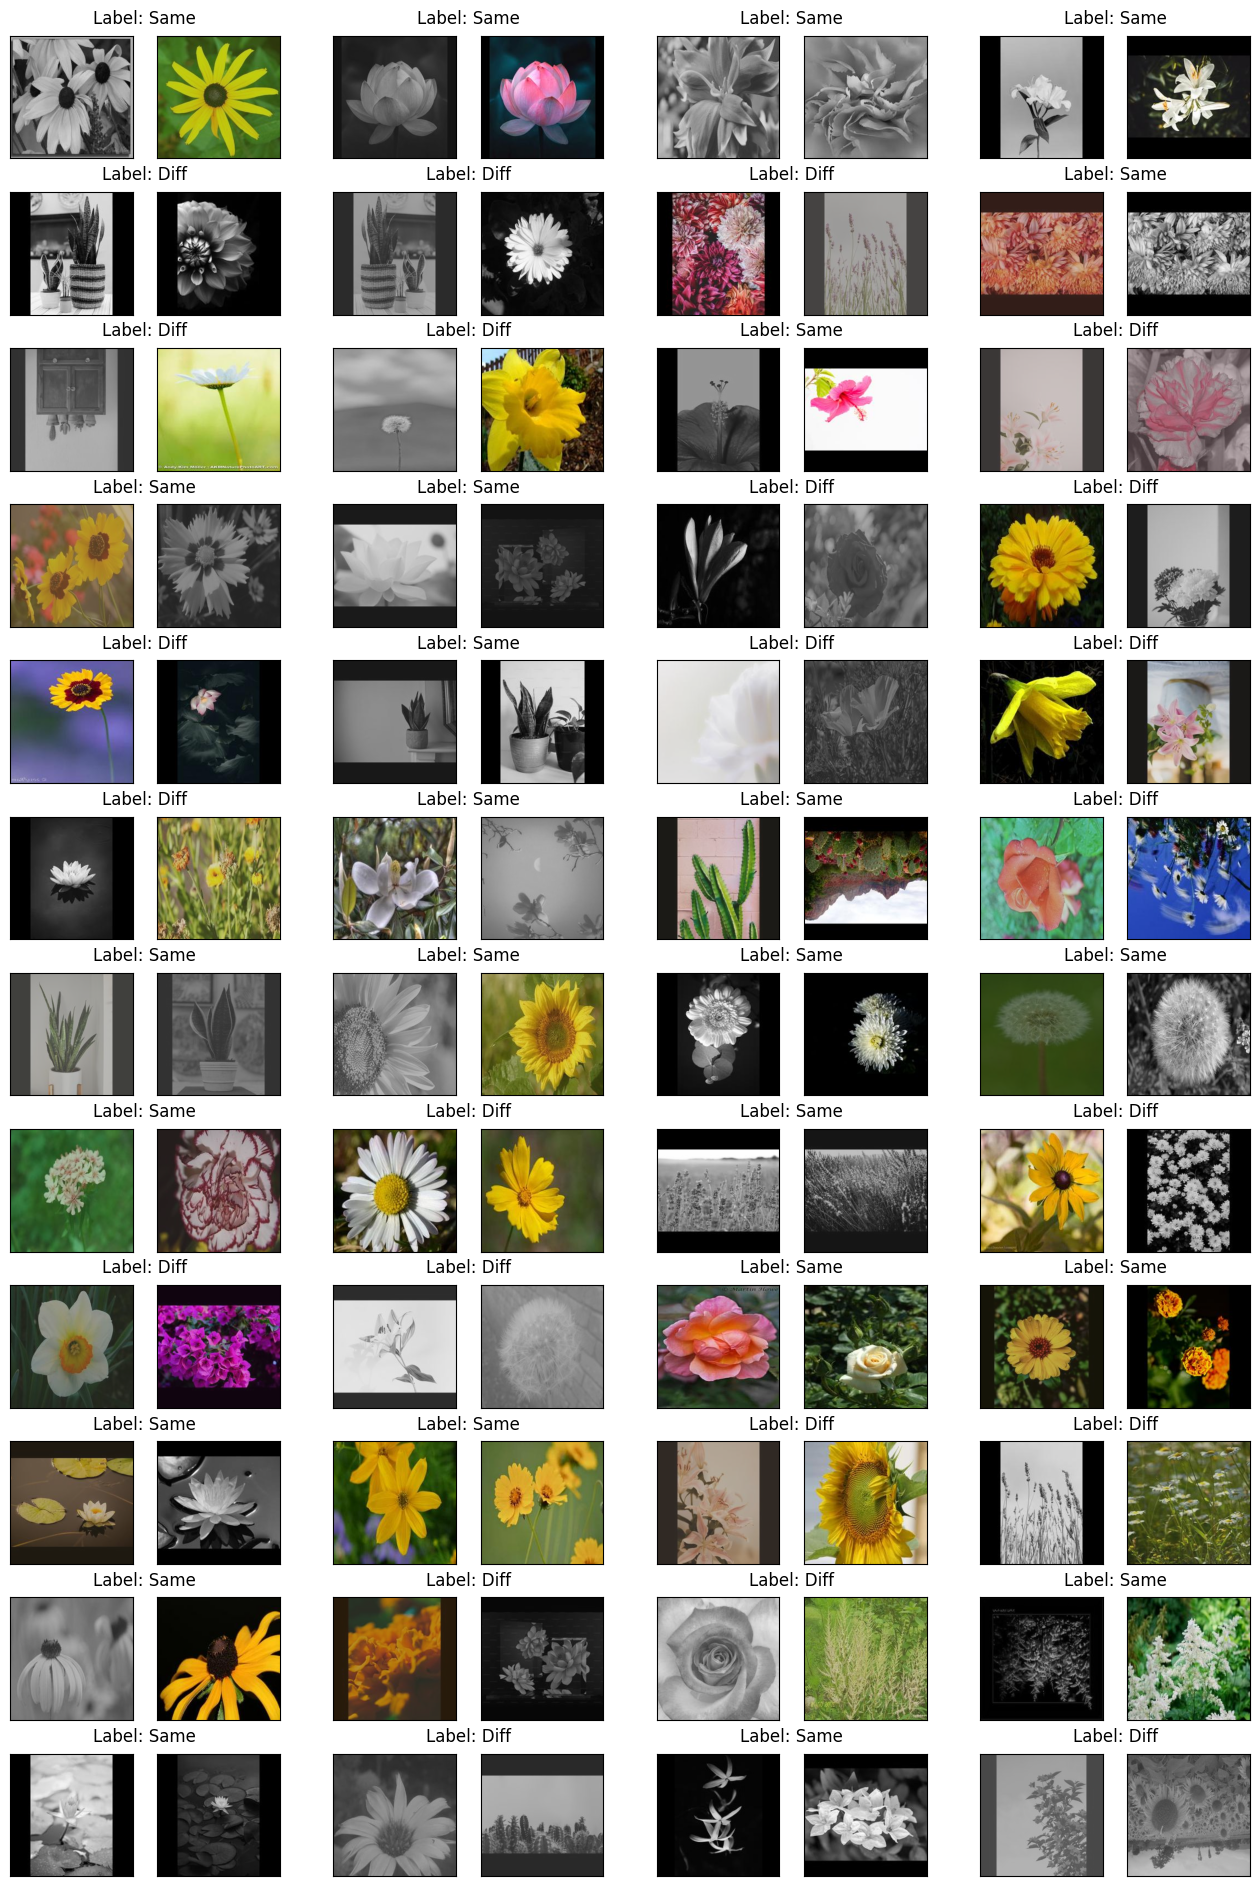

In [9]:
class_names = ['aloe-vera', 'astilbe', 'bellflower', 'black-eyed-susan', 'bougainvillea', 'calendula', 'california-poppy', 'carnation', 'chrysanthemum', 'common-daisy', 'coreopsis', 'daffodil',
               'dahlia', 'dandelion', 'golden-barrel-cactus', 'hibiscus', 'iris', 'jasmine', 'lavender', 'lily', 'lotus', 'magnolia', 'marigold', 'rose', 'snake-plant', 'sunflower', 'tulip', 'water-lily']

peek_pairs(training_dataset)

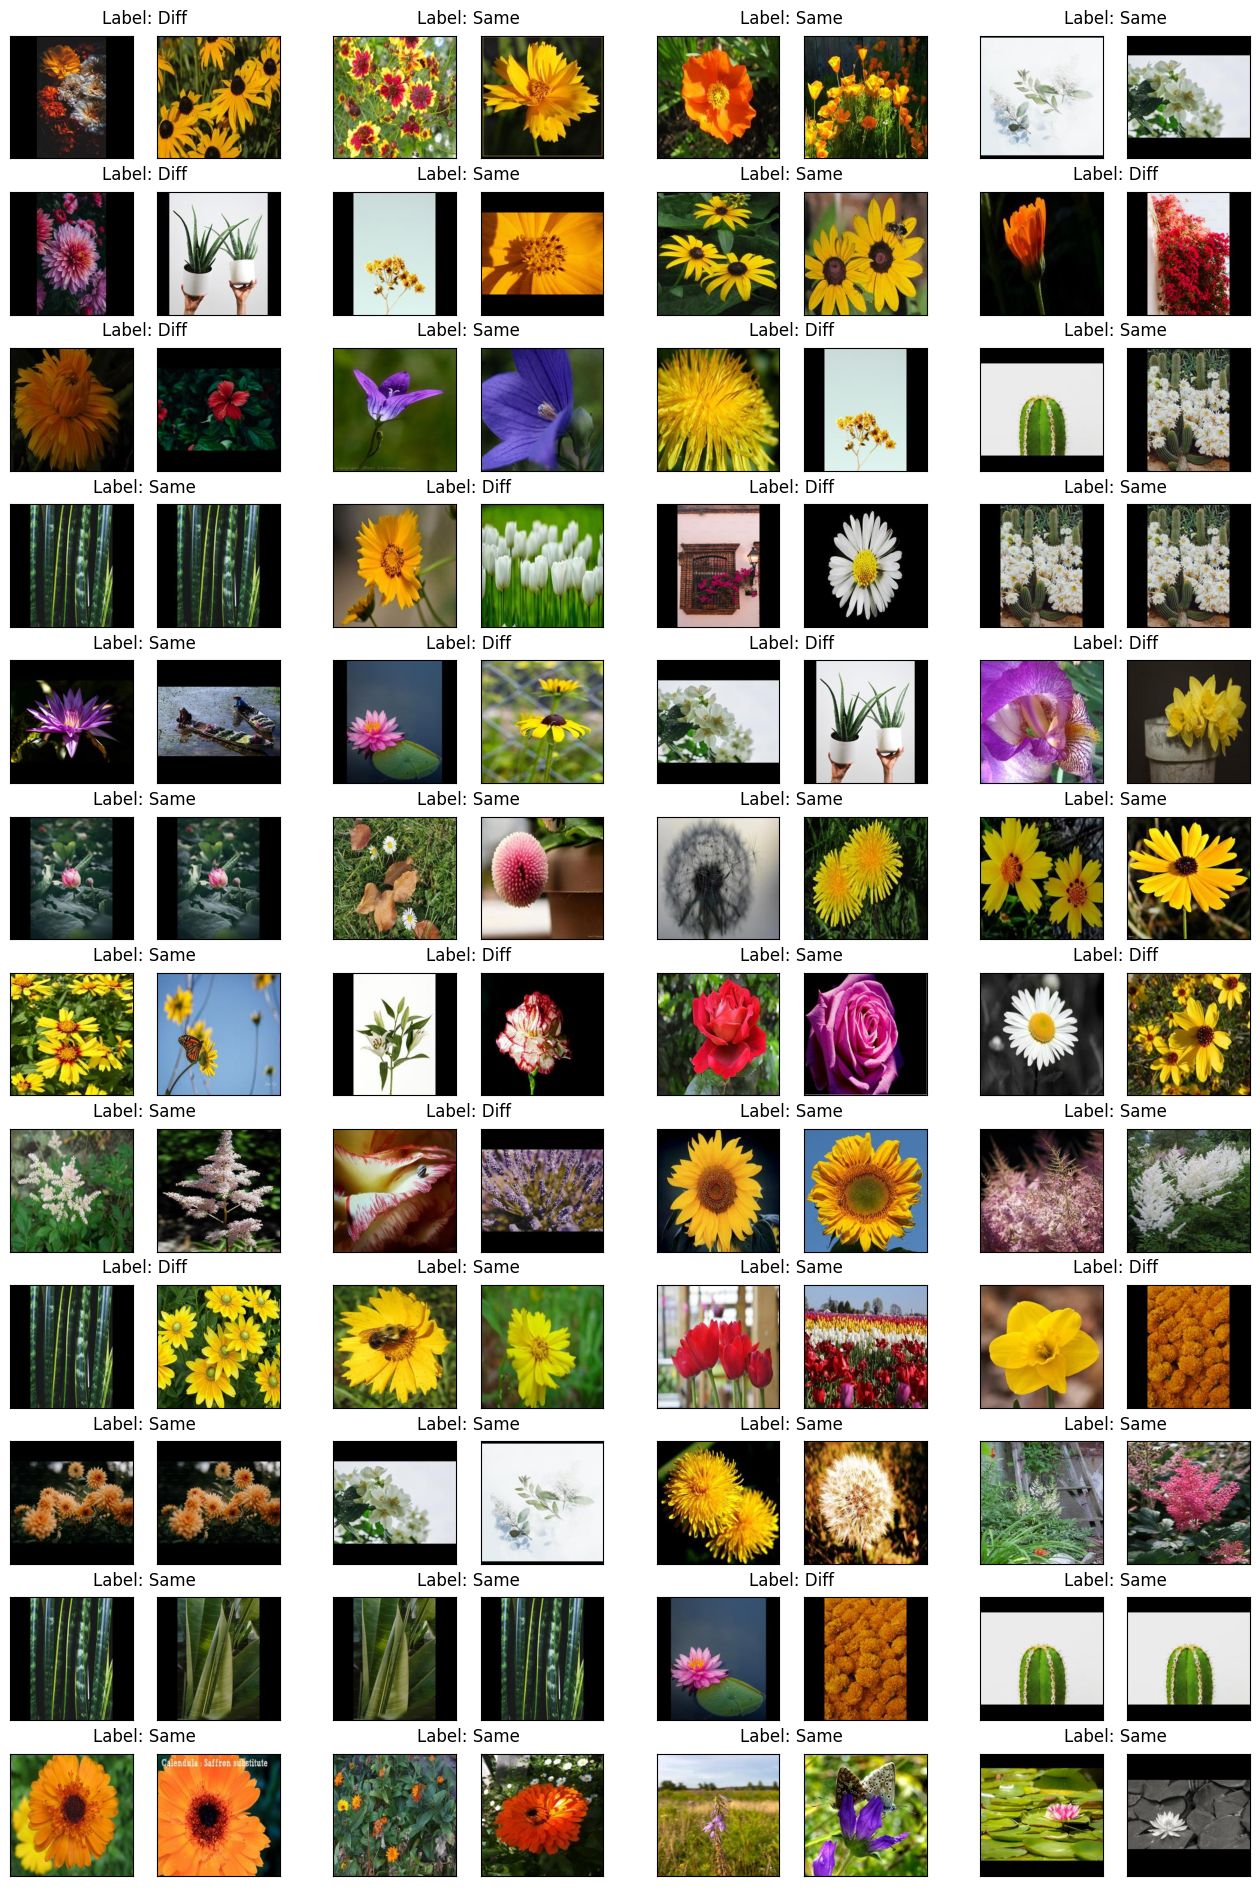

In [10]:
peek_pairs(validation_dataset)

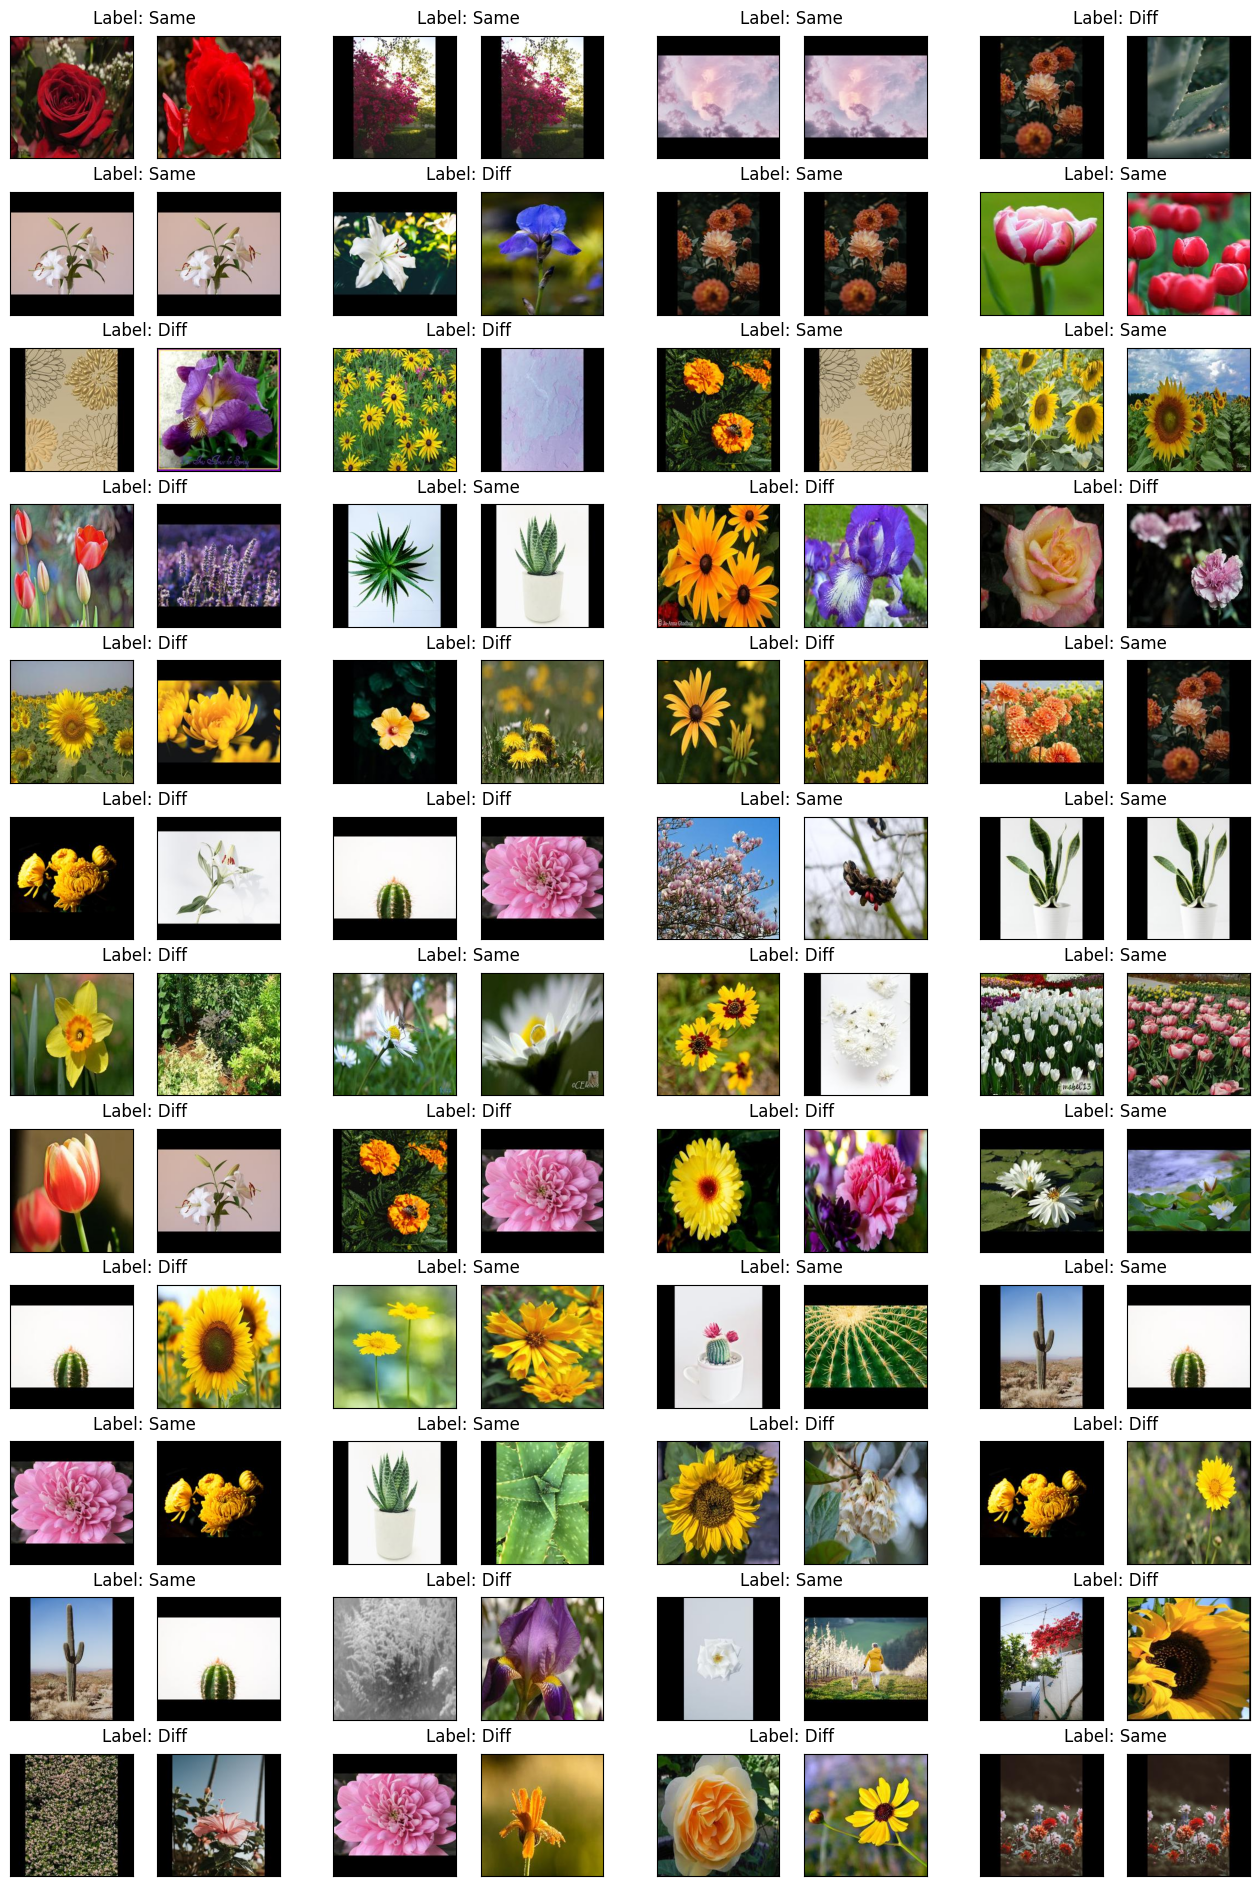

In [11]:
peek_pairs(testing_dataset)

## 3. Build Model


In [12]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub


class L1_layer(Model):
    def __init__(self, **kwargs):
        super(L1_layer, self).__init__(**kwargs)

    def call(self, tensors):
        x, y = tensors
        distance = tf.math.abs(x - y)
        return distance

def build_feature_extractor(feature_size=1024):
    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(DIMENSIONS, DIMENSIONS, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor.trainable = True
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    feature_extractor = feature_extractor(input_layer, training=True)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    output_layer = layers.Dense(feature_size, activation='sigmoid')(flatten_layer)

    return Model(inputs=input_layer, outputs=output_layer, name="feature_extractor")

def build_discriminator(feature_size=1024):
    input_layer_left = layers.Input(shape=(feature_size))
    input_layer_right = layers.Input(shape=(feature_size))

    distance_layer = L1_layer()([input_layer_left, input_layer_right])
    dropout_layer = layers.Dropout(0.2)(distance_layer)
    hidden_layer = layers.Dense(8, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

    return Model([input_layer_left, input_layer_right], outputs=output_layer, name=f"discriminator")
    
feature_extractor_model = build_feature_extractor() if False else models.load_model(f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{VERSION_TAG}.keras')
discriminator_model = build_discriminator() if BUILD_MODEL else models.load_model(f'{DEVELOPMENT_MODEL_PATH}/discriminator-v{VERSION_TAG}.keras')

def build_model():
    input_layer_left = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    input_layer_right = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))

    feature_layer_left = feature_extractor_model(input_layer_left)
    feature_layer_right = feature_extractor_model(input_layer_right)

    output_layer = discriminator_model([feature_layer_left, feature_layer_right])

    model = Model(inputs=[input_layer_left, input_layer_right], outputs=output_layer, name="oneshot-classifier" )

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_model()

model.summary()






Model: "oneshot-classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 feature_extractor (Functio  (None, 1024)                 3569728   ['input_3[0][0]',             
 nal)                                                                'input_4[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 1)                    8209      ['featur

## 4. Train Model


In [13]:
%%time

VERSION = "0.3.1"
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{VERSION}"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# callbacks=[checkpoint_callback]
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset)


Epoch 1/30

10/10 [==============================] - 116s 10s/step - loss: 0.6581 - accuracy: 0.5479 - val_loss: 0.6351 - val_accuracy: 0.5354
Epoch 2/30
10/10 [==============================] - 77s 8s/step - loss: 0.6278 - accuracy: 0.5375 - val_loss: 0.6236 - val_accuracy: 0.5396
Epoch 3/30
10/10 [==============================] - 89s 8s/step - loss: 0.5749 - accuracy: 0.6396 - val_loss: 0.6205 - val_accuracy: 0.5542
Epoch 4/30
10/10 [==============================] - 74s 7s/step - loss: 0.5466 - accuracy: 0.6708 - val_loss: 0.6011 - val_accuracy: 0.5958
Epoch 5/30
10/10 [==============================] - 72s 7s/step - loss: 0.4982 - accuracy: 0.7708 - val_loss: 0.5686 - val_accuracy: 0.6396
Epoch 6/30
10/10 [==============================] - 109s 11s/step - loss: 0.4795 - accuracy: 0.7833 - val_loss: 0.5464 - val_accuracy: 0.6875
Epoch 7/30
10/10 [==============================] - 89s 9s/step - loss: 0.4802 - accuracy: 0.7771 - val_loss: 0.5285 - val_accuracy: 0.7479
Epoch 8/30
10/1

KeyboardInterrupt: 

### 4.2 Training Result


In [14]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

NameError: name 'history' is not defined

## 5. Test Model


In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

10/10 [==============================] - 25s 2s/step - loss: 0.4480 - accuracy: 0.8083
Test loss: 0.44800278544425964 Test accuracy: 0.8083333373069763


## 6. Visualize Result


10/10 [==============================] - 26s 2s/step


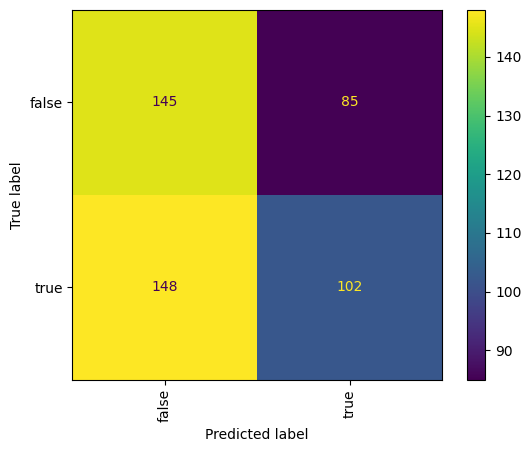

In [16]:
from sklearn import metrics

true_labels = []
for _, labels in testing_dataset:
    true_labels.extend(tf.cast(labels, tf.int8).numpy()) 

predictions = model.predict(testing_dataset)
predicted_labels = tf.cast(tf.squeeze(tf.math.round(predictions)), tf.int8).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['false', 'true'])

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model


In [17]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG  # "0.0.0"

models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{VERSION_TAG}.keras', save_format="keras")
models.save_model(discriminator_model, f'{DEVELOPMENT_MODEL_PATH}/discriminator-v{VERSION_TAG}.keras', save_format="keras")

# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras', save_format="keras")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="tf")